In [2]:
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.transform import resize
from skimage.io import imread

#%%
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
from sklearn.model_selection import train_test_split

2024-07-25 07:23:13.138964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 07:23:13.156778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 07:23:13.162175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 07:23:13.175412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from keras.utils import to_categorical
import pandas as pd

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize([128,128])).flatten() / 255.0

X_train = [] # ELA converted images
X_test = [] 
Y_train = [] # 0 for fake, 1 for real
Y_test = [] # 0 for fake, 1 for real

In [6]:
def split_dataset(image_paths, test_size=0.2):
    train_paths, test_paths = train_test_split(image_paths, test_size=test_size, random_state=42)
    return train_paths, test_paths

In [8]:
def load_and_preprocess_images(image_paths, label):
    X = []
    Y = []
    for path in image_paths:
        X.append(prepare_image(path))
        Y.append(label)
    return np.array(X), np.array(Y)

In [5]:
path_original = "casia-20-image-tampering-detection-dataset/CASIA2/Au"
path_tampered = "casia-20-image-tampering-detection-dataset/CASIA2/Tp"

total_orig = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [6]:
from tqdm import tqdm
images = []

for file in tqdm(total_orig):  #choose all pristine
    try:
        valid_extensions = ['jpg', 'bmp', 'png']
        if file.endswith(tuple(valid_extensions)):
            line = path_original + '/' + file  + ',0\n'
            images.append(line)
    except:
        print(path_original+file)
        
for file in tqdm(total_tampered):       #choose all tampered images
    try:
        valid_extensions = ['jpg', 'tif', 'png']
        if file.endswith(tuple(valid_extensions)):
                line = path_tampered + '/' + file + ',1\n'
                images.append(line)

    except:
          print(path_tampered+file)

100%|██████████| 5125/5125 [00:00<00:00, 1193018.54it/s]


In [7]:
len(images)

12614

In [8]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████| 12614/12614 [00:00<00:00, 1676977.10it/s]


In [9]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [10]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize([128,128])).flatten() / 255.0

In [11]:
def preprocess_image(image_path):
    return prepare_image(image_path).reshape(-1,128,128,3)

In [12]:
kernel = [
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0,-1 ,1, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0,-1 ,0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 1,-1 ,0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0,-1 ,0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0,-1 ,0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0,-1 ,0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0,-1 ,0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0,-1 ,0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 1,-2 ,1, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0,-2 ,0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0,-2 ,0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0,-2 ,0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 1,-3 ,3,-1],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0,-1, 0, 0],
            [0, 0, 3, 0, 0],
            [0, 0,-3 ,0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [-1,3,-3 ,1, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0,-3 ,0, 0],
            [0, 0, 3, 0, 0],
            [0, 0,-1, 0, 0],
        ],
        [
            [0, 0, 0, 0,-1],
            [0, 0, 0, 3, 0],
            [0, 0,-3 ,0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [-1,0, 0, 0, 0],
            [0, 3, 0, 0, 0],
            [0, 0,-3 ,0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0,-3 ,0, 0],
            [0, 3, 0, 0, 0],
            [-1,0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0,-3, 0, 0],
            [0, 0, 0, 3, 0],
            [0, 0, 0, 0,-1],
        ],
        [
            [0, 0, 0, 0, 0],
            [0,-1, 2,-1, 0],
            [0, 2,-4, 2, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0,-1, 2, 0, 0],
            [0, 2,-4 ,0, 0],
            [0,-1, 2, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 2,-4, 2, 0],
            [0,-1, 2,-1, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 2,-1, 0],
            [0, 0,-4 ,2, 0],
            [0, 0, 2,-1, 0],
            [0, 0, 0, 0, 0],
        ],
        
        [
            [0, 0, 0, 0, 0],
            [0,-1, 2,-1, 0],
            [0, 2,-4 ,2, 0],
            [0,-1, 2,-1, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [-1,2,-2, 2,-1],
            [2,-6, 8,-6, 2],
            [-2,8,-12,8,-2],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        [
            [-1, 2,-2, 0, 0],
            [ 2,-6, 8, 0, 0],
            [-2,8,-12 ,1, 0],
            [ 2,-6, 8, 0, 0],
            [-1, 2,-2, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [-2,8,-12,8,-2],
            [2,-6, 8,-6, 2],
            [-1,2,-2, 2,-1],
        ],
        [
            [0,0,-2, 2, -1],
            [0,0, 8, -6, 2],
            [0,0,-12 ,8, -2],
            [0,0, 8, -6, 2],
            [0,0,-2, 2,-1],
        ],
        [
            [-1,2,-2, 2, -1],
            [2,-6, 8, -6, 2],
            [-2,8,-12 ,8, -2],
            [2,-6, 8, -6, 2],
            [-1,2,-2, 2,-1],
        ]]

In [13]:
y = []
for x in kernel:
    maxi = max(max(i) for i in x)
    y += [[[i/maxi for i in y] for y in x]]

In [14]:
kernel = np.array(y)

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Define the 30 SRM filters (only a few are shown for brevity)
filters = kernel

def convert_to_3_channel_filters(filters):
    """
    Converts a list of 2D filters to 3-channel filters.
    
    Args:
    filters (numpy.ndarray): A NumPy array of shape (num_filters, height, width).
    
    Returns:
    numpy.ndarray: A NumPy array of shape (num_filters, height, width, 3).
    """
    # Check if filters are already 2D NumPy arrays
    if filters.ndim == 3:
        filters_3_channel = np.stack([filters, filters, filters], axis=-1)
        return filters_3_channel
    else:
        raise ValueError("Input filters must be a 3D NumPy array (num_filters, height, width).")

# Convert to 3-channel filters
filters_3_channel = convert_to_3_channel_filters(filters)

def apply_filters(image, filters, amplification_factor=1):
    """
    Apply 3-channel filters to an image.
    
    Args:
    image (numpy.ndarray): An RGB image of shape (height, width, 3).
    filters (numpy.ndarray): A NumPy array of 3-channel filters of shape (num_filters, height, width, 3).
    amplification_factor (float): Factor to amplify the filter response.
    
    Returns:
    numpy.ndarray: An array of noise feature maps.
    """
    noise_maps = []
    for f in filters:
        noise_map_channels = []
        for c in range(3):  # Apply filter to each channel
            noise_map = cv2.filter2D(image[:, :, c], -1, f[:, :, c]) #* amplification_factor
            noise_map_channels.append(noise_map)
        noise_map = np.stack(noise_map_channels, axis=-1)  # Combine the three channels
        noise_maps.append(noise_map)
    return np.array(noise_maps)

def enhance_contrast(image):
    """
    Enhance the contrast of an image.
    
    Args:
    image (numpy.ndarray): An image of shape (height, width, channels).
    
    Returns:
    numpy.ndarray: The contrast-enhanced image.
    """
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced_image



In [18]:
def srm(image_path):
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply the filters to the image with amplification
    amplification_factor = 10  # Increase this factor to amplify the noise response
    noise_maps = apply_filters(image, filters_3_channel, amplification_factor)

    # Combine the noise maps to visualize the noise residual
    combined_noise_map = np.sum(noise_maps, axis=0)

    # Enhance the contrast of the noise residual image
    enhanced_noise_map = enhance_contrast(combined_noise_map.astype(np.uint8))

    return enhanced_noise_map
    #return cv2.resize(enhanced_noise_map, (128, 128))

In [ ]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

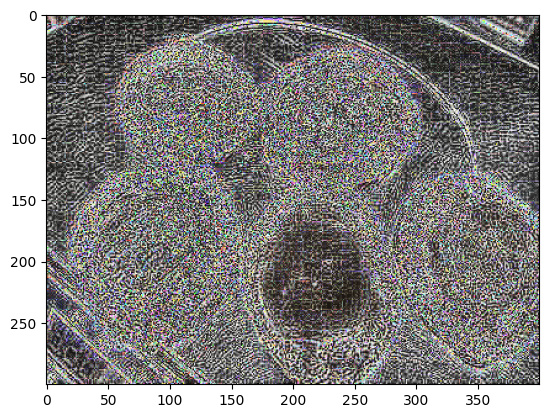

In [23]:
plt.imshow(srm(dataset.iloc[0]['image']))

In [21]:
X_ela = []
Y_ela = []

In [22]:
for index, row in dataset.iterrows():
    X_ela.append(prepare_image(row[0]))
    Y_ela.append(row[1])

In [62]:
Y_casia_ela = to_categorical(Y_ela, 2)
X_casia_ela = np.array(X_ela).reshape(-1, 128, 128, 3)

In [63]:
len(X_ela)

12614

In [64]:
X_casia_ela.shape

(12614, 128, 128, 3)

In [52]:
X_noise = []
Y_noise = []

In [53]:
for index, row in dataset.iterrows():
    X_noise.append(np.array(resize(srm(row[0]), (128, 128, 3))))
    Y_noise.append(row[1])

In [65]:
len(X_noise)

12614

In [69]:
X_casia_noise = np.array(X_noise)

In [72]:
Y_casia_noise = to_categorical(Y_noise, 2)

In [73]:
Y_casia_noise.shape

(12614, 2)

In [66]:
f = np.array(resize(srm(dataset.iloc[0]['image']), (512, 512, 3)))

In [48]:
f.shape

(512, 512, 3)

In [37]:
np.shape(X_noise[7])

(256, 384, 3)

In [16]:
x_casia = np.array(X_ela)
y_casia = np.array(Y_ela)

In [17]:
x_casia = x_casia.reshape(-1, 128, 128, 3)

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(x_casia, y_casia, test_size = 0.2, random_state=5)
###model cnn

In [20]:
Y_train.shape

(10091,)

In [21]:
Y_train = to_categorical(Y_train, 2)

In [22]:
Y_val = to_categorical(Y_val, 2)

In [23]:
Y_train.shape

(10091, 2)

In [24]:
Y_val.shape

(2523, 2)

In [79]:
X_casia_ela.shape

(12614, 128, 128, 3)

In [79]:
optimizer = Adam()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 115200)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               29491456  
                                                      

In [25]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: (10091, 128, 128, 3)
Y_train shape: (10091, 2)


In [94]:
export TF_GPU_ALLOCATOR=cuda_malloc_async

SyntaxError: invalid syntax (1015962112.py, line 1)

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
import cv2
import numpy as np

# Load and preprocess the ELA image and Noise Map
def load_and_preprocess_image(image_path, size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    image = image / 255.0  # Normalize the image
    return image

# Paths to the images
#ela_image_path = '/mnt/data/ela_image.png'  # Replace with the actual path to your ELA image
#noise_map_path = '/mnt/data/image.png'      # Replace with the actual path to your Noise Map

# Load the images
ela_image = X_casia_ela
noise_map = X_casia_noise

# Expand dimensions to create a batch of one image (required for model input)
#ela_image = np.expand_dims(ela_image, axis=0)
#noise_map = np.expand_dims(noise_map, axis=0)

# Define the model
def create_dual_branch_model(input_shape):
    # Branch for ELA image
    ela_input = Input(shape=input_shape, name='ELA_Input')
    x1 = Conv2D(32, (3, 3), activation='relu')(ela_input)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(32, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)
    x1 = Dropout(0.25)(x1)

    # Branch for Noise Map
    noise_input = Input(shape=input_shape, name='Noise_Input')
    x2 = Conv2D(32, (3, 3), activation='relu')(noise_input)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(32, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)
    x2 = Dropout(0.25)(x2)

    # Concatenate the outputs of the two branches
    concatenated = Concatenate()([x1, x2])
    x = Dense(256, activation='relu')(concatenated)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    # Create the model
    model = Model(inputs=[ela_input, noise_input], outputs=output)
    return model

# Create the model
input_shape = (128, 128, 3)
model = create_dual_branch_model(input_shape)

# Compile the model
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()
model.fit([X_casia_ela, X_casia_noise],Y_casia_ela, epochs=10, batch_size=10)
# Example of model prediction
# Here we use dummy data for the demonstration, you should use real data for actual predictions
dummy_labels = np.array([[1, 0]])  # Example labels
predictions = model.predict([X_casia_ela, X_casia_noise])
print("Predictions:", predictions)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ELA_Input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Noise_Input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 126,  │        896 │ ELA_Input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 126, 126,  │        896 │ Noise_Input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 63,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 63, 63,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 61,    │      9,248 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 61, 61,    │      9,248 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 30,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 30, 30,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 28800)     │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 28800)     │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 28800)     │          0 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 28800)     │          0 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 57600)     │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │ 14,745,856 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        514 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,766,658 (56.33 MB)

 Trainable params: 14,766,658 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

2024-07-25 10:04:45.404013: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB (rounded to 2480013312)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-25 10:04:45.406626: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-07-25 10:04:45.407545: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 52, Chunks in use: 52. 13.0KiB allocated for chunks. 13.0KiB in use in bin. 2.2KiB client-requested in use in bin.
2024-07-25 10:04:45.408538: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-07-25 10:04:45.408547: I exter

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [90]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Split data into training and testing sets
split = int(0.8 * num_samples)
X_ela_train, X_ela_test = X_ela[:split], X_ela[split:]
X_noise_train, X_noise_test = X_noise[:split], X_noise[split:]
y_train, y_test = y[:split], y[split:]

# Define input shapes
input_shape = img_shape

# Input layers
input_ela = layers.Input(shape=input_shape, name='ELA_Image')
input_noise = layers.Input(shape=input_shape, name='Noise_Map')

# Convolutional branch for ELA image
ela = layers.Conv2D(32, (3, 3), activation='relu')(input_ela)
ela = layers.MaxPooling2D((2, 2))(ela)
ela = layers.Conv2D(32, (3, 3), activation='relu')(ela)
ela = layers.MaxPooling2D((2, 2))(ela)
ela = layers.Conv2D(32, (3, 3), activation='relu')(ela)
ela = layers.MaxPooling2D((2, 2))(ela)

# Convolutional branch for Noise Map
noise = layers.Conv2D(32, (3, 3), activation='relu')(input_noise)
noise = layers.MaxPooling2D((2, 2))(noise)
noise = layers.Conv2D(32, (3, 3), activation='relu')(noise)
noise = layers.MaxPooling2D((2, 2))(noise)
noise = layers.Conv2D(32, (3, 3), activation='relu')(noise)
noise = layers.MaxPooling2D((2, 2))(noise)

# Concatenate the feature maps
concatenated = layers.Concatenate()([ela, noise])
concatenated = layers.Dropout(0.25)(concatenated)

# Fully connected layers
flatten = layers.Flatten()(concatenated)
fc = layers.Dense(256, activation='relu')(flatten)
fc = layers.Dropout(0.5)(fc)

# Output layer
output = layers.Dense(2, activation='softmax')(fc)

# Define the model
model = models.Model(inputs=[input_ela, input_noise], outputs=output)

# Compile the model
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model
history = model.fit([X_ela_train, X_noise_train], y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate([X_ela_test, X_noise_test], y_test)
print(f'Test accuracy: {test_acc}')
